In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import torch
import seaborn as sns
from typing import Sequence

In [3]:
from domino.sdm.gmm import ErrorGMM, GMM

In [4]:
PARAM_A = 3
PARAM_B = 1

def generate_data(n_data, means, covariances, weights, classes, errors):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    X = np.zeros((n_data, n_features))
    y = np.zeros(n_data)
    y_hat = np.zeros(n_data)
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        X[i] = np.random.multivariate_normal(means[k], covariances[k])
        if classes[k] == 1:
            y[i] = np.random.beta(PARAM_A, PARAM_B) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
            else:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
        else: 
            y[i] = np.random.beta(PARAM_B, PARAM_A) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
            else:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
      
    return X,y, y_hat

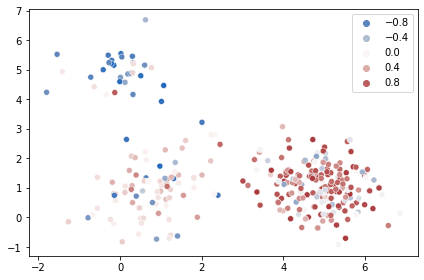

In [5]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 1],
    [1, 1],
    [0, 5],
    [5, 1],
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 8, 1 / 4, 1 / 8, 1 / 2]

# generate data
#np.random.seed(4)
X,y, y_hat = generate_data(300, init_means, init_covariances, init_weights, [0, 1, 0, 1], [0, 0, 1, 1])

sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=y - y_hat,
    palette="vlag"
)#torch.nn.functional.binary_cross_entropy(torch.tensor(y_hat), torch.tensor(y), reduction="none").numpy())
plt.tight_layout()

In [6]:
def plot_contours(data, means, covs, errors, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko', alpha=0.3)

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(
            x_grid, y_grid, z_grid, 10,    
            colors=np.stack(10 * [sns.color_palette("viridis", as_cmap=True)(errors[i])])
        )
    
    plt.title(title)
    plt.tight_layout()

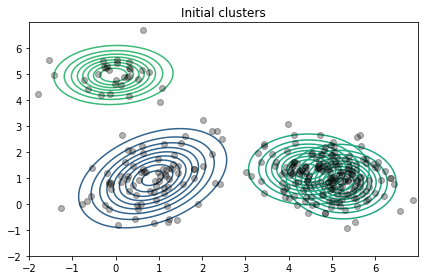

In [21]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
gmm = ErrorGMM(n_components = 4, max_iter = 10000, tol = 1e-4)
gmm.fit(X, y, y_hat)

plot_contours(X, gmm.means_, gmm.covariances_, gmm.errors_, 'Initial clusters')

In [24]:
gmm._estimate_error_log_prob(y, y_hat).mean(axis=0)

array([-0.71325973, -0.69654295, -0.74372667, -0.71742256])

In [25]:
gmm._estimate_log_prob(X).mean(axis=0)

array([-15.66627002, -12.80177522, -46.34492737, -10.59186511])

In [120]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
n_dims = 100
from sklearn.datasets import make_spd_matrix
init_means = np.array([
    np.random.randn(n_dims) * (i +1 ) for i in range(4)]
)

init_covariances = np.array(
    [make_spd_matrix(n_dims)] * 4
)

init_weights = [1 / 8, 1 / 4, 1 / 8, 1 / 2]

# generate data
#np.random.seed(4)
X,y, y_hat = generate_data(300, init_means, init_covariances, init_weights, [0, 1, 0, 1], [0, 0, 1, 1])

In [121]:
gmm = ErrorGMM(n_components = 4, max_iter = 1000, tol = 1e-4)
gmm.fit(X, y, y_hat)

ErrorGMM(max_iter=1000, n_components=4, tol=0.0001)

In [122]:
gmm.errors_

array([0.66354332, 0.66842858, 0.27839262, 0.3209207 ])

In [33]:
gmm.weights[0]

nan